In [1]:
# from google.colab import drive
# drive.mount('/gdrive')

## Import Statement

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets , transforms
from torch.optim import lr_scheduler

from tqdm import tqdm

import random
import PIL
from PIL import Image

from torch.autograd import Variable
from collections import OrderedDict
import math
from pathlib import Path
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch version {torch.__version__}\nPIL version {PIL.__version__}\nDevice {device}")


torch version 2.5.1+cu121
PIL version 11.0.0
Device cuda


## Objective
1. Get more than 85% accuracy
2. Less then 200k  parameter
3. Use Data Augmentation
4. Use Depthwise Separable Convolution
5. Use Dilated Convolution

## Dataset

### Mean and Std calculation for Normalization

In [3]:
dataset = datasets.CIFAR10(train=True,root="data/" , download=True)
mean = np.mean(dataset.data ,axis=(0,1,2))
std = np.std(dataset.data ,axis=(0,1,2))
print(f"\nMean is {mean}\nStd dev is  {std}")

100%|██████████| 170M/170M [00:05<00:00, 30.5MB/s]


Extracting data/cifar-10-python.tar.gz to data/

Mean is [125.30691805 122.95039414 113.86538318]
Std dev is  [62.99321928 62.08870764 66.70489964]


In [4]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.9/269.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 31.0 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [6]:
# # Calculate the mean of CIFAR-10 dataset (mean and std of CIFAR-10 dataset)
# mean = [0.4914, 0.4822, 0.4465]  # Mean of CIFAR-10 images (RGB)
# std = [0.2470, 0.2435, 0.2616]   # Standard deviation of CIFAR-10 images (RGB)

# Define Albumentations transform pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
    A.ShiftScaleRotate(
        shift_limit=0.0625,  # Horizontal/vertical shift in range [-0.0625, 0.0625]
        scale_limit=0.1,     # Scale factor range: [1-0.1, 1+0.1]
        rotate_limit=15,     # Rotate range in degrees
        p=0.2                # Apply with 70% probability
    ),
    A.CoarseDropout(
        max_holes=1,          # Maximum number of holes to drop
        max_height=16,        # Maximum height of the holes
        max_width=16,         # Maximum width of the holes
        min_holes=1,          # Minimum number of holes to drop
        min_height=16,        # Minimum height of the holes
        min_width=16,         # Minimum width of the holes
        fill_value=mean,      # Fill the dropout area with the mean of the dataset
        mask_fill_value=None, # No mask fill (optional)
        p=0.2                 # Apply with 20% probability
    ),
    A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) ,
    ToTensorV2(),
       # Convert image to a PyTorch tensor
])

# Custom Dataset class to use Albumentations with CIFAR-10
class AlbumentationsCIFAR10(datasets.CIFAR10):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super().__init__(root, train=train, transform=None, target_transform=target_transform, download=download)  # Set transform to None here
        self.albumentations_transform = transform

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        if self.albumentations_transform:
            img = np.array(img)  # Convert PIL image to numpy array
            img = self.albumentations_transform(image=img)['image']  # Apply Albumentations
        else:
            if self.transform is not None:  # Apply torchvision transforms if albumentations is not used
                img = self.transform(img)
        return img, target

# Load CIFAR-10 dataset and apply the Albumentations transform
train_dataset = AlbumentationsCIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=True)

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example of how to iterate over the DataLoader
for images, labels in train_loader:
    # Your training loop here
    print(images.shape)  # Should be (batch_size, 3, 32, 32)
    break

<ipython-input-6-1d829b32f9b7>:14: UserWarning: Argument 'fill_value' is not valid and will be ignored.
  A.CoarseDropout(
<ipython-input-6-1d829b32f9b7>:14: UserWarning: Argument 'mask_fill_value' is not valid and will be ignored.
  A.CoarseDropout(


Files already downloaded and verified
Files already downloaded and verified
torch.Size([64, 3, 32, 32])


In [7]:
def denormalize(image):
  mean = torch.tensor([0.5, 0.5, 0.5])
  std = torch.tensor([0.5, 0.5, 0.5])
  image = image.clone().detach().to("cpu") # take out of computational graph
  image = image.squeeze()
  image = image.permute(1,2,0) # channel swapping H*W*C
  image.mul_(std).add_(mean) # denormalize

  return image.numpy()

### Augmentation Visualization
side by side comparison of original Image and augmented Image

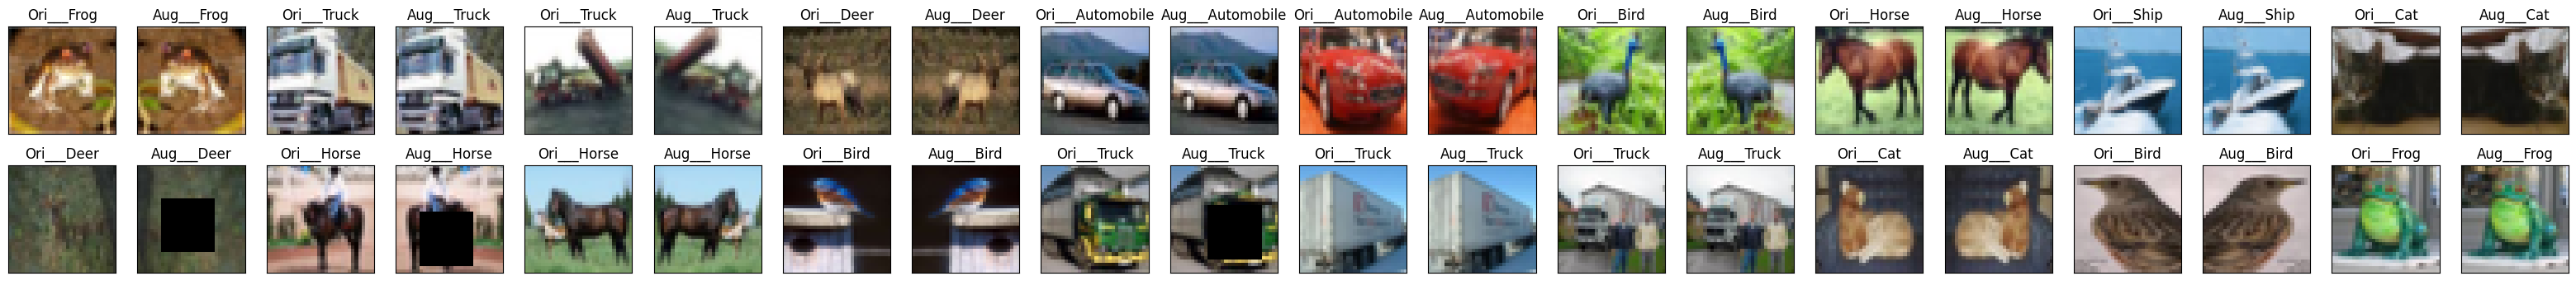

In [8]:
def show_img(ax,img,text):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.grid(False)
  ax.imshow(img)
  ax.set_title(text.title())

def visualizeAugmentation(augSet , normalset , no_of_images=8):
  """
    Visualizing Augmentation with normal set
    :augset : Augmented dataset
    :normalset :Normal dataset with no Augmentation
  """
  fig = plt.figure(figsize=(no_of_images*2,4))

  l = [x for x in range(1,2*no_of_images+1)] #indexing purpose

  for i in range(no_of_images):

    ax  = fig.add_subplot(2,no_of_images,l[::2][i]) #odd numbers
    ax2 = fig.add_subplot(2,no_of_images,l[1::2][i]) #even numbers

    show_img(ax , normalset[i][0],f"ori___{normalset.classes[normalset[i][1]]}")
    show_img(ax2 , denormalize(augSet[i][0]) , f"aug___{augSet.classes[augSet[i][1]]}")

visualizeAugmentation(train_dataset , dataset,no_of_images=20)

In [9]:
# Load CIFAR-10 dataset and apply the Albumentations transform
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])
test_transforms = transforms.Compose([transforms.ToTensor() ,
                                     transforms.Normalize(mean=mean , std=std)
                                    ])
# train_dataset = AlbumentationsCIFAR10(root='./data', train=True, transform=transform, download=True)
train_dataset = AlbumentationsCIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=test_transforms, download=True)

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
n_samples = 0
for inputs, _ in tqdm(train_loader, desc="Calculating Mean and Std", total=len(train_loader)):
    # Accumulate sum and square sum for each channel
    batch_samples = inputs.size(0)  # Number of images in the batch
    inputs = inputs.numpy()  # Convert to numpy for easier manipulation

    mean += np.sum(inputs, axis=(0, 2, 3))  # Sum over batch and spatial dimensions
    std += np.sum(inputs**2, axis=(0, 2, 3))  # Sum of squared values over batch and spatial dimensions

    n_samples += batch_samples

# Finalize the mean and std by dividing by the number of samples
mean /= (n_samples * 32 * 32)  # 32x32 is the image size for CIFAR-10
std = np.sqrt(std / (n_samples * 32 * 32) - mean**2)  # Apply formula for std

print(f"Calculated mean: {mean}")
print(f"Calculated std: {std}")

Calculating Mean and Std: 100%|██████████| 782/782 [00:30<00:00, 25.81it/s]

Calculated mean: tensor([-0.0668, -0.0832, -0.1509])
Calculated std: tensor([0.5256, 0.5178, 0.5449])


In [11]:
n_samples = 0
for inputs, _ in tqdm(test_loader, desc="Calculating Mean and Std", total=len(test_loader)):
    # Accumulate sum and square sum for each channel
    batch_samples = inputs.size(0)  # Number of images in the batch
    inputs = inputs.numpy()  # Convert to numpy for easier manipulation

    mean += np.sum(inputs, axis=(0, 2, 3))  # Sum over batch and spatial dimensions
    std += np.sum(inputs**2, axis=(0, 2, 3))  # Sum of squared values over batch and spatial dimensions

    n_samples += batch_samples

# Finalize the mean and std by dividing by the number of samples
mean /= (n_samples * 32 * 32)  # 32x32 is the image size for CIFAR-10
std = np.sqrt(std / (n_samples * 32 * 32) - mean**2)  # Apply formula for std

print(f"Calculated mean: {mean}")
print(f"Calculated std: {std}")

Calculating Mean and Std: 100%|██████████| 157/157 [00:02<00:00, 54.57it/s]

Calculated mean: tensor([-0.0116, -0.0297, -0.0992])
Calculated std: tensor([0.4933, 0.4858, 0.5232])


In [12]:
next(iter(train_loader))

[tensor([[[[ 0.2863,  0.2941,  0.3490,  ...,  0.1294,  0.1137,  0.0980],
           [ 0.2235,  0.1922,  0.3412,  ...,  0.1216,  0.1059,  0.0980],
           [ 0.2549,  0.1294,  0.2863,  ...,  0.1137,  0.0980,  0.0902],
           ...,
           [ 0.0039, -0.0118, -0.0196,  ..., -0.0510, -0.0824, -0.0118],
           [-0.0275, -0.0275, -0.0588,  ..., -0.0039, -0.0588, -0.0980],
           [-0.0275, -0.0667, -0.1216,  ...,  0.0902,  0.0588, -0.0353]],
 
          [[ 0.3647,  0.3725,  0.4353,  ...,  0.2157,  0.1922,  0.1843],
           [ 0.2941,  0.2706,  0.4275,  ...,  0.2314,  0.2157,  0.2000],
           [ 0.3255,  0.2000,  0.3569,  ...,  0.2392,  0.2235,  0.2078],
           ...,
           [-0.0745, -0.0824, -0.0902,  ..., -0.0902, -0.1216, -0.0510],
           [-0.1137, -0.1137, -0.1529,  ..., -0.0510, -0.1059, -0.1451],
           [-0.1059, -0.1529, -0.2314,  ...,  0.0118, -0.0196, -0.1216]],
 
          [[ 0.5843,  0.5529,  0.5843,  ...,  0.4824,  0.4667,  0.4510],
           [ 

In [13]:
next(iter(test_loader))

[tensor([[[[ 0.2392,  0.2471,  0.2941,  ...,  0.0745, -0.0118, -0.0902],
           [ 0.1922,  0.1843,  0.2471,  ...,  0.0667, -0.0196, -0.0667],
           [ 0.1843,  0.1843,  0.2392,  ...,  0.0902,  0.0196, -0.0588],
           ...,
           [-0.4667, -0.6706, -0.7569,  ..., -0.7020, -0.8980, -0.6863],
           [-0.5216, -0.6157, -0.7255,  ..., -0.7961, -0.7725, -0.8431],
           [-0.5765, -0.5608, -0.6471,  ..., -0.8118, -0.7333, -0.8353]],
 
          [[-0.1216, -0.1294, -0.0902,  ..., -0.2549, -0.2863, -0.3333],
           [-0.1216, -0.1373, -0.1059,  ..., -0.2549, -0.2863, -0.3098],
           [-0.1373, -0.1451, -0.1294,  ..., -0.2314, -0.2549, -0.3020],
           ...,
           [-0.0275, -0.2157, -0.3098,  ..., -0.2392, -0.4980, -0.3333],
           [-0.0902, -0.2000, -0.3333,  ..., -0.3569, -0.3569, -0.4980],
           [-0.1608, -0.1765, -0.3020,  ..., -0.3961, -0.3412, -0.4745]],
 
          [[-0.6157, -0.6314, -0.6000,  ..., -0.7176, -0.7176, -0.7412],
           [-

### Transformation and Dataset Defination

In [14]:
# train_transforms = transforms.Compose([transforms.RandomCrop(size=32 , padding=4 , padding_mode="symmetric",pad_if_needed=True),
#                                        transforms.RandomHorizontalFlip(p=0.5),
#                                        transforms.ToTensor(),
#                                        #transforms.Normalize(mean = mean , std=std)
#                                       ])

# val_transforms = transforms.Compose([transforms.ToTensor() ,
#                                      #transforms.Normalize(mean=mean , std=std)
#                                     ])

# mean = torch.from_numpy(mean).type(torch.float32)
# std = torch.from_numpy(std).type(torch.float32)

# def denormalize(image):
#   image = image.clone().detach().to("cpu") # take out of computational graph
#   image = image.squeeze()
#   image = image.permute(1,2,0) # channel swapping H*W*C
#  # image.mul_(std).add_(mean) # denormalize

#   return image.numpy()

# trainset = datasets.CIFAR10(train=True,root="data/" , download=True,transform=train_transforms)
# valset  = datasets.CIFAR10(train=False,root="data/" , download=True,transform=val_transforms)

## Utility Func

###  No grad


In [15]:
from functools import wraps

def no_grad(func):
  @wraps(func)
  def wrapper(*args,**kwargs):
    with torch.no_grad():
      return func(*args,**kwargs)
  return wrapper

### Save Checkpoint

In [16]:
def save_checkpoint(epoch, epochs_since_improvement, model, optimizer,loss, best_loss, is_best,filepath=None):
    """
    Save model checkpoint.

    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement
    :param model: model
    :param optimizer: optimizer
    :param loss: validation loss in this epoch
    :param best_loss: best validation loss achieved so far (not necessarily in this checkpoint)
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'loss': loss,
             'best_loss': best_loss,
             'model': model.state_dict(),
             'optimizer': optimizer.state_dict()}
    filename = Path("./convnet/checkpoint.pt") if filepath is None else filepath
    is_best = is_best if filepath is None else False
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state,   Path("./convnet/BEST_checkpoint.pt"))

## Model Definition

### Calculate Summary

In [17]:
@no_grad
def summary(model, input_size, batch_size=-1, device="cuda"):

    def register_hook(module):

        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            m_key = "%s-%i" % (class_name, module_idx + 1)
            summary[m_key] = OrderedDict()
            summary[m_key]["input_shape"] = list(input[0].size())
            summary[m_key]["input_shape"][0] = batch_size
            if isinstance(output, (list, tuple)):
                summary[m_key]["output_shape"] = [
                    [-1] + list(o.size())[1:] for o in output
                ]
            else:
                summary[m_key]["output_shape"] = list(output.size())
                summary[m_key]["output_shape"][0] = batch_size

            params = 0
            if hasattr(module, "weight") and hasattr(module.weight, "size"):
                params += torch.prod(torch.LongTensor(list(module.weight.size())))
                summary[m_key]["trainable"] = module.weight.requires_grad
            if hasattr(module, "bias") and hasattr(module.bias, "size"):
                params += torch.prod(torch.LongTensor(list(module.bias.size())))
            summary[m_key]["nb_params"] = params

        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
            and not (module == model)
        ):
            hooks.append(module.register_forward_hook(hook))

    device = device.lower()
    assert device in [
        "cuda",
        "cpu",
    ], "Input device is not valid, please specify 'cuda' or 'cpu'"

    if device == "cuda" and torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    # multiple inputs to the network
    if isinstance(input_size, tuple):
        input_size = [input_size]

    # batch_size of 2 for batchnorm
    x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
    # print(type(x[0]))

    # create properties
    summary = OrderedDict()
    hooks = []
    model = model.to(device)
    # register hook
    model.apply(register_hook)

    # make a forward pass
    # print(x.shape)
    model(*x)

    # remove these hooks
    for h in hooks:
        h.remove()

    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
    print(line_new)
    print("================================================================")
    total_params = 0
    total_output = 0
    trainable_params = 0
    for layer in summary:
        # input_shape, output_shape, trainable, nb_params
        line_new = "{:>20}  {:>25} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"]),
        )
        total_params += summary[layer]["nb_params"]
        total_output += np.prod(summary[layer]["output_shape"])
        if "trainable" in summary[layer]:
            if summary[layer]["trainable"] == True:
                trainable_params += summary[layer]["nb_params"]
        print(line_new)

    # assume 4 bytes/number (float on cuda).
    total_input_size = abs(np.prod(input_size) * batch_size * 4. / (1024 ** 2.))
    total_output_size = abs(2. * total_output * 4. / (1024 ** 2.))  # x2 for gradients
    total_params_size = abs(total_params.numpy() * 4. / (1024 ** 2.))
    total_size = total_params_size + total_output_size + total_input_size

    del model

    print("================================================================")
    print("Total params: {0:,}".format(total_params))
    print("Trainable params: {0:,}".format(trainable_params))
    print("Non-trainable params: {0:,}".format(total_params - trainable_params))
    print("----------------------------------------------------------------")
    print("Input size (MB): %0.2f" % total_input_size)
    print("Forward/backward pass size (MB): %0.2f" % total_output_size)
    print("Params size (MB): %0.2f" % total_params_size)
    print("Estimated Total Size (MB): %0.2f" % total_size)
    print("----------------------------------------------------------------")
    return total_params

# Custom ConvNet

In [18]:

# import torch
# import torch.nn as nn

# # Define the ConvBlock class
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(ConvBlock, self).__init__()

#         # Conv1 -> BatchNorm -> ReLU
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu1 = nn.ReLU(inplace=True)

#         # Conv2 -> BatchNorm -> ReLU
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.relu2 = nn.ReLU(inplace=True)

#         # Conv3 -> BatchNorm -> ReLU
#         self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)
#         self.bn3 = nn.BatchNorm2d(out_channels)
#         self.relu3 = nn.ReLU(inplace=True)

#     def forward(self, x):
#         # Apply Conv1 -> BatchNorm -> ReLU
#         x = self.relu1(self.bn1(self.conv1(x)))

#         # Apply Conv2 -> BatchNorm -> ReLU
#         x = self.relu2(self.bn2(self.conv2(x)))

#         # Apply Conv3 -> BatchNorm -> ReLU
#         x = self.relu3(self.bn3(self.conv3(x)))

#         return x

# # Define the Transition Block class
# class TransitionBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, dropout_prob=0.01, last_block=False):
#         super(TransitionBlock, self).__init__()

#         # 1x1 Convolution to reduce the number of channels
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)

#         if not last_block:
#             # Apply BatchNorm and ReLU, unless it's the last transition block
#             self.bn = nn.BatchNorm2d(out_channels)
#             self.relu = nn.ReLU(inplace=True)

#             # Dropout layer (only applied after transition blocks except the last)
#             self.dropout = nn.Dropout(p=dropout_prob)
#         else:
#             # No BatchNorm or ReLU for the last transition block
#             self.bn = None
#             self.relu = None
#             self.dropout = None

#     def forward(self, x):
#         # Apply 1x1 Conv
#         x = self.conv(x)

#         if self.bn is not None:
#             # Apply BatchNorm
#             x = self.bn(x)

#         if self.relu is not None:
#             # Apply ReLU
#             x = self.relu(x)

#         if self.dropout is not None:
#             # Apply Dropout
#             x = self.dropout(x)

#         return x

# # Define the CIFARModel with ConvBlock, TransitionBlock, and Dropout
# class CIFARModel(nn.Module):
#     def __init__(self, num_classes=10, dropout_prob=0.01):
#         super(CIFARModel, self).__init__()

#         # Convolutional Blocks: 4 Blocks, each having 3 conv layers with BatchNorm and ReLU
#         self.block1 = ConvBlock(in_channels=3, out_channels=64)
#         self.transition1 = TransitionBlock(in_channels=64, out_channels=32, dropout_prob=dropout_prob)

#         self.block2 = ConvBlock(in_channels=32, out_channels=64)
#         self.transition2 = TransitionBlock(in_channels=64, out_channels=32, dropout_prob=dropout_prob)

#         self.block3 = ConvBlock(in_channels=32, out_channels=64)
#         self.transition3 = TransitionBlock(in_channels=64, out_channels=32, dropout_prob=dropout_prob)

#         self.block4 = ConvBlock(in_channels=32, out_channels=64)
#         self.transition4 = TransitionBlock(in_channels=64, out_channels=64, dropout_prob=0.0, last_block=True)  # No BatchNorm or ReLU

#         # Global Average Pooling (GAP)
#         self.gap = nn.AdaptiveAvgPool2d(1)

#         # Classification Layer: num_classes for flexible output
#         self.fc = nn.Linear(64, num_classes)  # `num_classes` can be any number

#     def forward(self, x):
#         # Pass through ConvBlock and TransitionBlock
#         x = self.block1(x)
#         x = self.transition1(x)

#         x = self.block2(x)
#         x = self.transition2(x)

#         x = self.block3(x)
#         x = self.transition3(x)

#         x = self.block4(x)
#         x = self.transition4(x)

#         # Apply Global Average Pooling
#         x = self.gap(x)

#         # Flatten the output of GAP
#         x = torch.flatten(x, 1)  # Flatten to shape (batch_size, 512)

#         # Fully connected layer for final classification
#         x = self.fc(x)

#         return x




In [36]:
import torch
import torch.nn as nn

# Depthwise Separable Convolution
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv2d, self).__init__()

        # Depthwise Convolution (each input channel has its own filter)
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels)

        # Pointwise Convolution (1x1 convolution to mix channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        # BatchNorm and ReLU (for standardization)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Apply depthwise convolution
        x = self.depthwise(x)

        # Apply pointwise convolution
        x = self.pointwise(x)

        # Apply BatchNorm and ReLU
        x = self.bn(x)
        x = self.relu(x)

        return x

# Dilated Convolution Block
class DilatedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=2, dilation=2):
        super(DilatedConv2d, self).__init__()

        # Dilated Convolution with a specified dilation rate
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation)

        # BatchNorm and ReLU (for standardization)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Apply Dilated Convolution
        x = self.conv(x)

        # Apply BatchNorm and ReLU
        x = self.bn(x)
        x = self.relu(x)

        return x

# Define the ConvBlock class with Depthwise Separable Convolution and Dilated Convolution
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_depthwise=False, use_dilated=False):
        super(ConvBlock, self).__init__()

        # Conv1 -> BatchNorm -> ReLU
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        # Conv2 -> BatchNorm -> ReLU (this will be replaced with a Dilated Conv if use_dilated is True)
        if use_dilated:
            self.conv2 = DilatedConv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=2, dilation=2)
        else:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        # Conv3 -> BatchNorm -> ReLU (this will be replaced with Depthwise Separable Conv if use_depthwise is True)
        if use_depthwise:
            self.conv3 = DepthwiseSeparableConv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)
        else:
            self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)

        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu3 = nn.ReLU(inplace=True)

    def forward(self, x):
        # Apply Conv1 -> BatchNorm -> ReLU
        x = self.relu1(self.bn1(self.conv1(x)))

        # Apply Conv2 -> BatchNorm -> ReLU (Dilated or Regular Conv)
        x = self.relu2(self.bn2(self.conv2(x)))

        # Apply Conv3 -> BatchNorm -> ReLU (Depthwise Separable or Regular Conv)
        x = self.relu3(self.bn3(self.conv3(x)))

        return x

# Define the Transition Block class
class TransitionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.01, last_block=False):
        super(TransitionBlock, self).__init__()

        # 1x1 Convolution to reduce the number of channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)

        if not last_block:
            # Apply BatchNorm and ReLU, unless it's the last transition block
            self.bn = nn.BatchNorm2d(out_channels)
            self.relu = nn.ReLU(inplace=True)

            # Dropout layer (only applied after transition blocks except the last)
            self.dropout = nn.Dropout(p=dropout_prob)
        else:
            # No BatchNorm or ReLU for the last transition block
            self.bn = None
            self.relu = None
            self.dropout = None

    def forward(self, x):
        # Apply 1x1 Conv
        x = self.conv(x)

        if self.bn is not None:
            # Apply BatchNorm
            x = self.bn(x)

        if self.relu is not None:
            # Apply ReLU
            x = self.relu(x)

        if self.dropout is not None:
            # Apply Dropout
            x = self.dropout(x)

        return x

# Define the CIFARModel with ConvBlock, TransitionBlock, and Dropout
class CIFARModel(nn.Module):
    def __init__(self, num_classes=10, dropout_prob=0.01):
        super(CIFARModel, self).__init__()

        # Convolutional Blocks: 4 Blocks, each having 3 conv layers with BatchNorm and ReLU
        self.block1 = ConvBlock(in_channels=3, out_channels=32, use_depthwise=True)
        self.transition1 = TransitionBlock(in_channels=32, out_channels=32, dropout_prob=dropout_prob)

        self.block2 = ConvBlock(in_channels=32, out_channels=64)
        self.transition2 = TransitionBlock(in_channels=64, out_channels=32, dropout_prob=dropout_prob)

        self.block3 = ConvBlock(in_channels=32, out_channels=32)
        self.transition3 = TransitionBlock(in_channels=32, out_channels=32, dropout_prob=dropout_prob)

        self.block4 = ConvBlock(in_channels=32, out_channels=32, use_dilated=True)
        self.transition4 = TransitionBlock(in_channels=32, out_channels=64, dropout_prob=0.0, last_block=True)  # No BatchNorm or ReLU

        # Global Average Pooling (GAP)
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Classification Layer: num_classes for flexible output
        self.fc = nn.Linear(64, num_classes)  # `num_classes` can be any number

    def forward(self, x):
        # Pass through ConvBlock and TransitionBlock
        x = self.block1(x)
        x = self.transition1(x)

        x = self.block2(x)
        x = self.transition2(x)

        x = self.block3(x)
        x = self.transition3(x)

        x = self.block4(x)
        x = self.transition4(x)

        # Apply Global Average Pooling
        x = self.gap(x)

        # Flatten the output of GAP
        x = torch.flatten(x, 1)  # Flatten to shape (batch_size, 512)

        # Fully connected layer for final classification
        x = self.fc(x)

        return x


In [53]:
totalparams = summary(CIFARModel(num_classes=len(train_dataset.classes)).to(device),(3,32,32));totalparams

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 16, 16]             320
            Conv2d-8           [-1, 32, 16, 16]           1,056
       BatchNorm2d-9           [-1, 32, 16, 16]              64
             ReLU-10           [-1, 32, 16, 16]               0
DepthwiseSeparableConv2d-11           [-1, 32, 16, 16]               0
      BatchNorm2d-12           [-1, 32, 16, 16]              64
             ReLU-13           [-1, 32, 16, 16]               0
        ConvBlock-14           [

In [22]:
from torchsummary import summary
summary(CIFARModel(num_classes=len(train_dataset.classes)).to(device),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 16, 16]             640
            Conv2d-8           [-1, 64, 16, 16]           4,160
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
DepthwiseSeparableConv2d-11           [-1, 64, 16, 16]               0
      BatchNorm2d-12           [-1, 64, 16, 16]             128
             ReLU-13           [-1, 64, 16, 16]               0
        ConvBlock-14           [

##  Parameters

In [38]:
batch_size=32
checkpoint = Path("./convnet/BEST_checkpoint.pt")
start_epoch = 0  # start at this epoch
epochs = 50  # number of epochs to run without early-stopping
epochs_since_improvement = 0  # number of epochs since there was an improvement in the validation metric
best_loss = 100.  # assume a high loss at first
workers = 4  # number of workers for loading data in the DataLoader
lr = 0.01  # learning rate
weight_decay = 1e-4  # weight decay
n_classes = len(train_dataset.classes)

## DataLoader

In [39]:
loader_param = { "batch_size":batch_size,
                 "pin_memory":True,
                 "num_workers":workers,
                "shuffle":True}

trainLoader = DataLoader(train_dataset,**loader_param)

valLoader = DataLoader(test_dataset  ,**loader_param)


## Averge Meter

In [40]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [41]:
def l2_loss(model,l2_lambda = 0.01):

  l2_reg = torch.tensor(0.)

  for param in model.parameters():
      l2_reg += torch.norm(param)

  loss += l2_lambda * l2_reg
  return loss


In [27]:
log_file_path = "train.txt"

## Train method

In [42]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: CrossEntropy loss
    :param optimizer :optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    losses = AverageMeter()  # loss
    accuracy = AverageMeter() # Accuracy meter

    # Batches
    for images, labels in train_loader:

        optimizer.zero_grad()
        # Move to default device
        images = images.to(device)
        labels = labels.to(device)

        # Forward prop.
        images = images.type(torch.float32)
        output = model(images)
        preds = torch.argmax(output,1)
        # Loss
        loss = criterion(output, labels)  # scalar

        #l2 loss
        # loss = loss + l2_loss(model)


        loss.backward()


        optimizer.step()

        losses.update(loss.item(), images.shape[0])
        accuracy.update(torch.sum(preds == labels.data).item())

        # Print status
    print(f"TRAIN  Loss {losses.avg}\t Accuracy {accuracy.sum/len(train_loader.dataset)}")
    with open(log_file_path, 'a') as f:
        f.write(f"TRAIN  Loss {losses.avg}\t Accuracy {accuracy.sum/len(train_loader.dataset)}\n")
    return losses.avg

## Validation method

In [43]:
@no_grad
def validate(val_loader, model, criterion):
    """
    One epoch's validation.

    :param val_loader: DataLoader for training data
    :param model: model
    :param criterion: CrossEntropy loss
    """
    model.eval()  # inference mode enables dropout

    losses = AverageMeter()  # loss
    accuracy = AverageMeter() # Accuracy meter

    # Batches
    for images, labels in val_loader:

        # Move to default device
        images = images.to(device)
        labels = labels.to(device)

        # Forward prop.
        images = images.type(torch.float32)
        output = model(images)
        preds = torch.argmax(output,1)
        # Loss
        loss = criterion(output, labels)  # scalar

        losses.update(loss.item(), images.shape[0])
        accuracy.update(torch.sum(preds == labels.data).item())


        # Print status
    print(f"VAL  Loss {losses.avg}\t Accuracy {accuracy.sum/len(val_loader.dataset)}")
    with open(log_file_path, 'a') as f:
        f.write(f"VAL  Loss {losses.avg}\t Accuracy {accuracy.sum/len(val_loader.dataset)}\n")
    return losses.avg

## Training

In [44]:
from tqdm import trange
def main(epochs):
  """

  Training and validation.
  """
  global epochs_since_improvement, start_epoch, best_loss, checkpoint
  model = CIFARModel(num_classes=n_classes)
  model = model.to(device)

  # specify loss function (categorical cross-entropy)
  criterion = nn.CrossEntropyLoss()

  # specify optimizer
  optimizer = optim.SGD(model.parameters(), lr=lr,weight_decay=weight_decay,momentum=0.9,nesterov=True,dampening=0)
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=4,min_lr=1e-5,verbose=True)

  # Initialize model or load checkpoint
  if checkpoint.exists():
    checkpoint_dict = torch.load(checkpoint)
    start_epoch = checkpoint_dict['epoch'] + 1
    epochs_since_improvement = checkpoint_dict['epochs_since_improvement']
    best_loss = checkpoint_dict['best_loss']

    print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
    model.load_state_dict(checkpoint_dict['model'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])

  # Epochs
  for epoch in trange(start_epoch,start_epoch+epochs):
      with open(log_file_path, 'a') as f:
        f.write(f"Epoch {epoch}\n")
        f.write(f"Current LR is {optimizer.param_groups[0]['lr']}\n")
      print("Current LR is " , optimizer.param_groups[0]['lr'])
      # One epoch's training
      train_loss = train(train_loader=trainLoader,
                         model=model,
                         criterion=criterion,
                         optimizer=optimizer,
                         epoch=epoch)

      # One epoch's validation
      val_loss = validate(val_loader=valLoader,
                          model=model,
                          criterion=criterion)
      scheduler.step(val_loss)
      # Did validation loss improve?
      is_best = val_loss < best_loss
      best_loss = min(val_loss, best_loss)

      if not is_best:
          epochs_since_improvement += 1
          print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
          with open(log_file_path, 'a') as f:
            f.write(f"Epochs since last improvement: {epochs_since_improvement}\n")

      else:
          epochs_since_improvement = 0

      # Save checkpoint
      save_checkpoint(epoch, epochs_since_improvement, model, optimizer, train_loss, best_loss, is_best)
  return model

In [45]:
model = main(epochs=epochs)

  0%|          | 0/50 [00:00<?, ?it/s]

Current LR is  0.01
TRAIN  Loss 1.6041285824012756	 Accuracy 0.40718


  2%|▏         | 1/50 [00:36<29:42, 36.39s/it]

VAL  Loss 1.2907615394592284	 Accuracy 0.5312
Current LR is  0.01
TRAIN  Loss 1.233640305480957	 Accuracy 0.55682


  4%|▍         | 2/50 [01:13<29:19, 36.66s/it]

VAL  Loss 1.042762547683716	 Accuracy 0.6333
Current LR is  0.01
TRAIN  Loss 1.076411616344452	 Accuracy 0.61568


  6%|▌         | 3/50 [01:49<28:28, 36.36s/it]

VAL  Loss 0.9242414187908172	 Accuracy 0.6716
Current LR is  0.01
TRAIN  Loss 0.9800555849838257	 Accuracy 0.65458


  8%|▊         | 4/50 [02:26<28:12, 36.80s/it]

VAL  Loss 0.8720010380744934	 Accuracy 0.696
Current LR is  0.01
TRAIN  Loss 0.9025050667381287	 Accuracy 0.6861


 10%|█         | 5/50 [03:01<27:06, 36.15s/it]

VAL  Loss 0.7780911430358887	 Accuracy 0.7283
Current LR is  0.01
TRAIN  Loss 0.8455364087677002	 Accuracy 0.70686


 12%|█▏        | 6/50 [03:39<26:55, 36.71s/it]

VAL  Loss 0.7127250772476196	 Accuracy 0.7508
Current LR is  0.01
TRAIN  Loss 0.8054788405799865	 Accuracy 0.71822


 14%|█▍        | 7/50 [04:13<25:46, 35.97s/it]

VAL  Loss 0.7170844312191009	 Accuracy 0.7538

Epochs since last improvement: 1

Current LR is  0.01
TRAIN  Loss 0.768030850162506	 Accuracy 0.73124


 16%|█▌        | 8/50 [04:51<25:28, 36.40s/it]

VAL  Loss 0.6691899203300476	 Accuracy 0.7645
Current LR is  0.01
TRAIN  Loss 0.7386505060005188	 Accuracy 0.74214


 18%|█▊        | 9/50 [05:25<24:23, 35.70s/it]

VAL  Loss 0.6565545334339142	 Accuracy 0.77
Current LR is  0.01
TRAIN  Loss 0.712555538187027	 Accuracy 0.75358


 20%|██        | 10/50 [05:59<23:29, 35.24s/it]

VAL  Loss 0.6414675449371338	 Accuracy 0.779
Current LR is  0.01
TRAIN  Loss 0.6892875838184357	 Accuracy 0.7619


 22%|██▏       | 11/50 [06:37<23:25, 36.04s/it]

VAL  Loss 0.6230244725704193	 Accuracy 0.7845
Current LR is  0.01
TRAIN  Loss 0.6674393397712708	 Accuracy 0.76864


 24%|██▍       | 12/50 [07:12<22:35, 35.68s/it]

VAL  Loss 0.6163057900428772	 Accuracy 0.7889
Current LR is  0.01
TRAIN  Loss 0.6523553461074829	 Accuracy 0.77292


 26%|██▌       | 13/50 [07:49<22:19, 36.20s/it]

VAL  Loss 0.599208554315567	 Accuracy 0.7935
Current LR is  0.01
TRAIN  Loss 0.6407487530136109	 Accuracy 0.77658


 28%|██▊       | 14/50 [08:24<21:22, 35.62s/it]

VAL  Loss 0.5636084974288941	 Accuracy 0.8028
Current LR is  0.01
TRAIN  Loss 0.6232011975765228	 Accuracy 0.7833


 30%|███       | 15/50 [09:00<20:59, 35.99s/it]

VAL  Loss 0.5849255882740021	 Accuracy 0.7954

Epochs since last improvement: 1

Current LR is  0.01
TRAIN  Loss 0.6043130455207825	 Accuracy 0.79088


 32%|███▏      | 16/50 [09:37<20:29, 36.15s/it]

VAL  Loss 0.5500903619289398	 Accuracy 0.8114
Current LR is  0.01
TRAIN  Loss 0.6001115163230896	 Accuracy 0.79206


 34%|███▍      | 17/50 [10:13<19:56, 36.25s/it]

VAL  Loss 0.5679438338756562	 Accuracy 0.804

Epochs since last improvement: 1

Current LR is  0.01
TRAIN  Loss 0.5870663322544097	 Accuracy 0.79522


 36%|███▌      | 18/50 [10:48<19:07, 35.87s/it]

VAL  Loss 0.568201684999466	 Accuracy 0.8069

Epochs since last improvement: 2

Current LR is  0.01
TRAIN  Loss 0.5746941497707367	 Accuracy 0.80012


 38%|███▊      | 19/50 [11:24<18:26, 35.68s/it]

VAL  Loss 0.5312411558389664	 Accuracy 0.817
Current LR is  0.01
TRAIN  Loss 0.5662339028930664	 Accuracy 0.80238


 40%|████      | 20/50 [12:00<17:57, 35.90s/it]

VAL  Loss 0.5325842555999756	 Accuracy 0.8152

Epochs since last improvement: 1

Current LR is  0.01
TRAIN  Loss 0.5616096709346772	 Accuracy 0.80692


 42%|████▏     | 21/50 [12:37<17:28, 36.17s/it]

VAL  Loss 0.523011389541626	 Accuracy 0.8203
Current LR is  0.01
TRAIN  Loss 0.5464039702320099	 Accuracy 0.81168


 44%|████▍     | 22/50 [13:14<17:01, 36.48s/it]

VAL  Loss 0.5551041973590851	 Accuracy 0.8111

Epochs since last improvement: 1

Current LR is  0.01
TRAIN  Loss 0.5429338387727738	 Accuracy 0.81036


 46%|████▌     | 23/50 [13:49<16:12, 36.02s/it]

VAL  Loss 0.5471767036437988	 Accuracy 0.8105

Epochs since last improvement: 2

Current LR is  0.01
TRAIN  Loss 0.5348291416358948	 Accuracy 0.81502


 48%|████▊     | 24/50 [14:27<15:51, 36.59s/it]

VAL  Loss 0.5457014312028885	 Accuracy 0.8157

Epochs since last improvement: 3

Current LR is  0.01
TRAIN  Loss 0.5307323929023743	 Accuracy 0.81476


 50%|█████     | 25/50 [15:01<14:59, 35.97s/it]

VAL  Loss 0.5185973693132401	 Accuracy 0.8232
Current LR is  0.01
TRAIN  Loss 0.5243802192497253	 Accuracy 0.81674


 52%|█████▏    | 26/50 [15:39<14:34, 36.42s/it]

VAL  Loss 0.5846921971321106	 Accuracy 0.8014

Epochs since last improvement: 1

Current LR is  0.01
TRAIN  Loss 0.5172052765464783	 Accuracy 0.82082


 54%|█████▍    | 27/50 [16:14<13:47, 35.96s/it]

VAL  Loss 0.49494389505386355	 Accuracy 0.8316
Current LR is  0.01
TRAIN  Loss 0.5071012854862214	 Accuracy 0.82532


 56%|█████▌    | 28/50 [16:48<13:00, 35.47s/it]

VAL  Loss 0.505732075047493	 Accuracy 0.8246

Epochs since last improvement: 1

Current LR is  0.01
TRAIN  Loss 0.510009948129654	 Accuracy 0.82158


 58%|█████▊    | 29/50 [17:26<12:39, 36.16s/it]

VAL  Loss 0.5667343730926514	 Accuracy 0.8105

Epochs since last improvement: 2

Current LR is  0.01
TRAIN  Loss 0.5018976910591125	 Accuracy 0.82652


 60%|██████    | 30/50 [18:00<11:53, 35.65s/it]

VAL  Loss 0.5200087031602859	 Accuracy 0.8246

Epochs since last improvement: 3

Current LR is  0.01
TRAIN  Loss 0.49393806965351106	 Accuracy 0.82892


 62%|██████▏   | 31/50 [18:37<11:22, 35.93s/it]

VAL  Loss 0.5029621395587921	 Accuracy 0.8289

Epochs since last improvement: 4

Current LR is  0.01
TRAIN  Loss 0.48522849235534665	 Accuracy 0.83166


 64%|██████▍   | 32/50 [19:12<10:43, 35.73s/it]

VAL  Loss 0.49001520910263063	 Accuracy 0.8334
Current LR is  0.01
TRAIN  Loss 0.48256886891365053	 Accuracy 0.8302


 66%|██████▌   | 33/50 [19:50<10:16, 36.26s/it]

VAL  Loss 0.501651637005806	 Accuracy 0.8276

Epochs since last improvement: 1

Current LR is  0.01
TRAIN  Loss 0.4784299294042587	 Accuracy 0.83458


 68%|██████▊   | 34/50 [20:34<10:18, 38.63s/it]

VAL  Loss 0.45780752241611483	 Accuracy 0.8437
Current LR is  0.01
TRAIN  Loss 0.479046497964859	 Accuracy 0.83262


 70%|███████   | 35/50 [21:12<09:36, 38.41s/it]

VAL  Loss 0.4889437970161438	 Accuracy 0.8337

Epochs since last improvement: 1

Current LR is  0.01
TRAIN  Loss 0.4733450896167755	 Accuracy 0.83772


 72%|███████▏  | 36/50 [21:48<08:49, 37.86s/it]

VAL  Loss 0.4807072458028793	 Accuracy 0.8371

Epochs since last improvement: 2

Current LR is  0.01
TRAIN  Loss 0.46764462257385253	 Accuracy 0.83656


 74%|███████▍  | 37/50 [22:27<08:13, 37.98s/it]

VAL  Loss 0.4987393880844116	 Accuracy 0.8309

Epochs since last improvement: 3

Current LR is  0.01
TRAIN  Loss 0.4614530029582977	 Accuracy 0.84


 76%|███████▌  | 38/50 [23:04<07:32, 37.67s/it]

VAL  Loss 0.4910694330692291	 Accuracy 0.8339

Epochs since last improvement: 4

Current LR is  0.01
TRAIN  Loss 0.46188965663433074	 Accuracy 0.83896


 78%|███████▊  | 39/50 [23:40<06:51, 37.44s/it]

VAL  Loss 0.4987741990327835	 Accuracy 0.8319

Epochs since last improvement: 5

Current LR is  0.001
TRAIN  Loss 0.3831477761673927	 Accuracy 0.86752


 80%|████████  | 40/50 [24:17<06:12, 37.26s/it]

VAL  Loss 0.4218045848369598	 Accuracy 0.8593
Current LR is  0.001
TRAIN  Loss 0.35952689958333967	 Accuracy 0.87546


 82%|████████▏ | 41/50 [24:53<05:31, 36.87s/it]

VAL  Loss 0.4166311945676804	 Accuracy 0.8616
Current LR is  0.001
TRAIN  Loss 0.3450040341091156	 Accuracy 0.87994


 84%|████████▍ | 42/50 [25:28<04:48, 36.10s/it]

VAL  Loss 0.41471768019199373	 Accuracy 0.862
Current LR is  0.001
TRAIN  Loss 0.3380955702829361	 Accuracy 0.8828


 86%|████████▌ | 43/50 [26:05<04:15, 36.44s/it]

VAL  Loss 0.41346522550582887	 Accuracy 0.8614
Current LR is  0.001
TRAIN  Loss 0.3345774479842186	 Accuracy 0.88576


 88%|████████▊ | 44/50 [26:39<03:34, 35.78s/it]

VAL  Loss 0.41017393980026245	 Accuracy 0.8616
Current LR is  0.001
TRAIN  Loss 0.3290896204948425	 Accuracy 0.8879


 90%|█████████ | 45/50 [27:13<02:56, 35.38s/it]

VAL  Loss 0.4102674934864044	 Accuracy 0.8628

Epochs since last improvement: 1

Current LR is  0.001
TRAIN  Loss 0.32591309918403627	 Accuracy 0.8871


 92%|█████████▏| 46/50 [27:51<02:24, 36.16s/it]

VAL  Loss 0.4158686957359314	 Accuracy 0.8631

Epochs since last improvement: 2

Current LR is  0.001
TRAIN  Loss 0.3256349574661255	 Accuracy 0.88754


 94%|█████████▍| 47/50 [28:26<01:47, 35.70s/it]

VAL  Loss 0.4133799375772476	 Accuracy 0.8619

Epochs since last improvement: 3

Current LR is  0.001
TRAIN  Loss 0.3259429306173325	 Accuracy 0.88744


 96%|█████████▌| 48/50 [29:04<01:13, 36.52s/it]

VAL  Loss 0.4082137391090393	 Accuracy 0.8645
Current LR is  0.001
TRAIN  Loss 0.31725030925273895	 Accuracy 0.89148


 98%|█████████▊| 49/50 [29:39<00:35, 35.94s/it]

VAL  Loss 0.4085090480327606	 Accuracy 0.8662

Epochs since last improvement: 1

Current LR is  0.001
TRAIN  Loss 0.31238633442640307	 Accuracy 0.89318


100%|██████████| 50/50 [30:15<00:00, 36.32s/it]

VAL  Loss 0.4110677458524704	 Accuracy 0.864

Epochs since last improvement: 2



## Per Class Accuracy

In [46]:
model = main(epochs=0)

<ipython-input-44-fd2c9331ff63>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_dict = torch.load(checkpoint)



Loaded checkpoint from epoch 48. Best loss so far is 0.408.



0it [00:00, ?it/s]


In [47]:
## load the model
@no_grad
def perClassAccuracy(model , classes):
  model = main(epochs=0)
  class_correct = np.zeros(len(classes) ,dtype =np.int64 )
  class_total = np.zeros_like(class_correct,dtype =np.int64 )
  model.eval()

  for data ,target in valLoader:
    data,target =data.to(device) , target.to(device)
    output =model(data)
    preds = torch.argmax(output,1)
    for prediction , label in zip(preds , target.data):
      if prediction == label:
        class_correct[prediction]+=1
      class_total[label]+=1
  per = np.round((100*class_correct/class_total) ,4)
  out = "\n".join([f"{name} :- {acc} %" for name ,acc in zip(classes , per)])
  return out+"\ntotal acc is {0}%".format(100* sum(class_correct)/sum(class_total))

print(perClassAccuracy(model , train_dataset.classes))

<ipython-input-44-fd2c9331ff63>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_dict = torch.load(checkpoint)



Loaded checkpoint from epoch 48. Best loss so far is 0.408.



0it [00:00, ?it/s]


airplane :- 86.5 %
automobile :- 95.4 %
bird :- 79.8 %
cat :- 72.4 %
deer :- 85.5 %
dog :- 76.4 %
frog :- 93.2 %
horse :- 89.5 %
ship :- 93.3 %
truck :- 92.5 %
total acc is 86.45%


## Intermediate Result :- Around 86 % Accuracy

## Visualizing the wrong prediction and where exactly model is confused

In [48]:
## load the model
model = main(epochs=0)
@no_grad
def allwrong_prediction(classes ,model):
  test_array =[]
  model.eval()
  for data ,target in valLoader:
    data,target =data.to(device) , target.to(device)
    output =model(data)
    preds = torch.argmax(output,1)
    for prediction , label in zip(preds , target.data):
      if prediction != label:
          test_array.append([data ,classes[prediction] ,classes[label]])
  return test_array

s = allwrong_prediction(train_dataset.classes , model)

<ipython-input-44-fd2c9331ff63>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_dict = torch.load(checkpoint)



Loaded checkpoint from epoch 48. Best loss so far is 0.408.



0it [00:00, ?it/s]


<ipython-input-49-1c08cd79ffd0>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gr.apply(len).unstack().plot(kind='bar', stacked=True, figsize=(20,10))


<Axes: xlabel='0'>

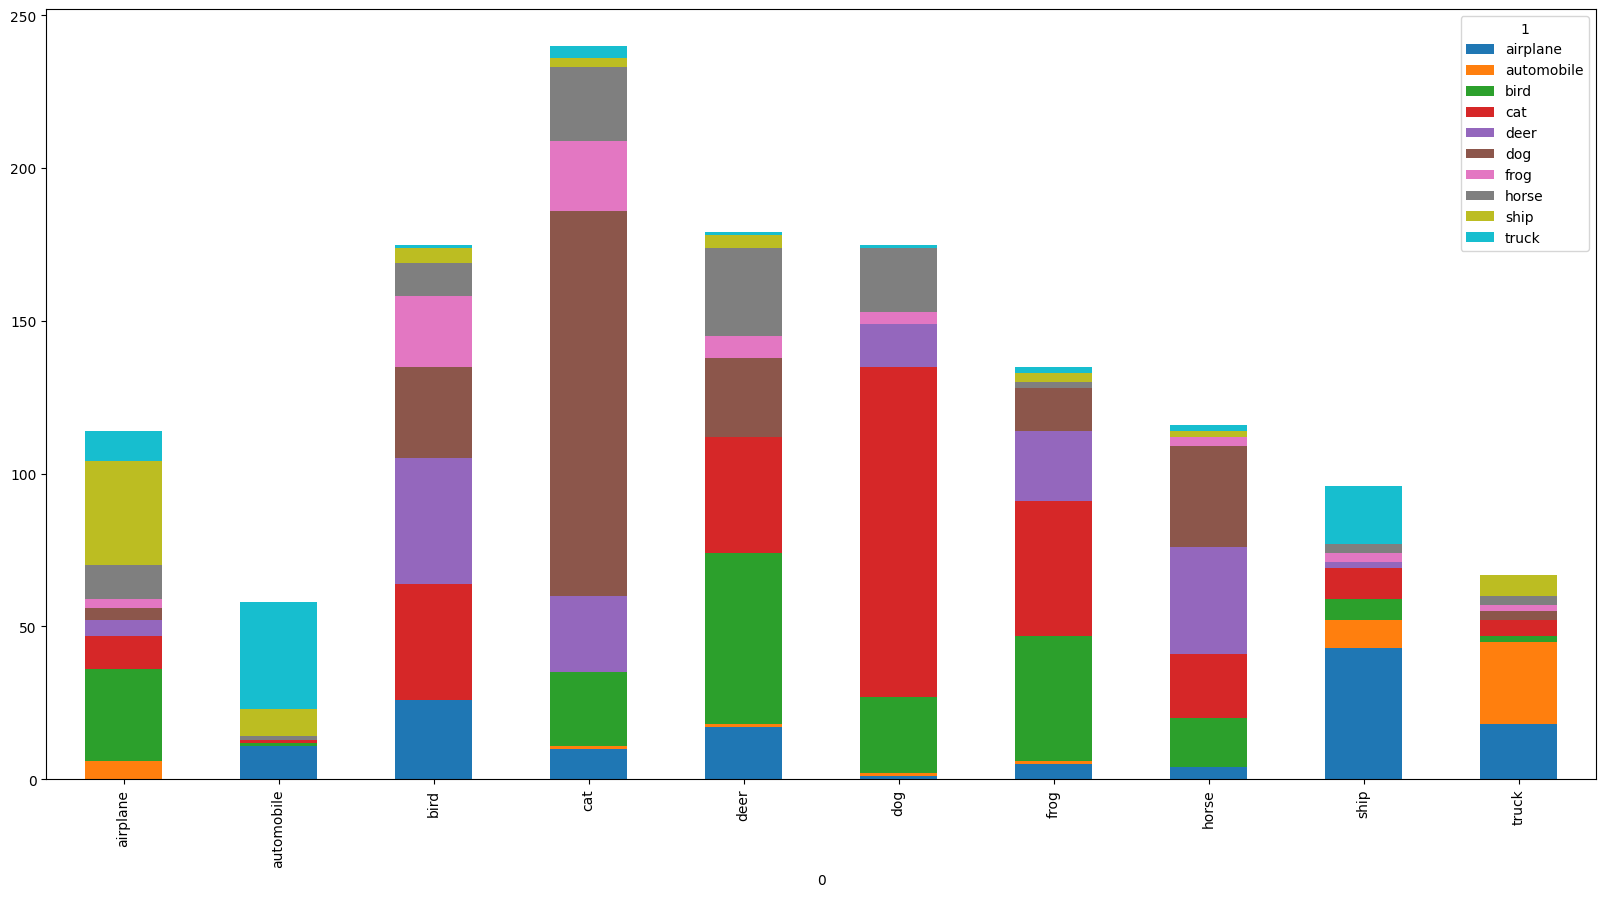

In [49]:
s_d = [(y,z) for x ,y,z in s]
df = pd.DataFrame(s_d)
gr = df.groupby([0,1])
gr.apply(len).unstack().plot(kind='bar', stacked=True, figsize=(20,10))

## Inferencing Graph
 Model is confused between airplane,ship,bird

## plot confusion matrix


In [52]:
from sklearn.metrics import classification_report, confusion_matrix
model = main(0)
pred = []
la=[]
with torch.no_grad():
  for image , label in valLoader:
    image , label = image.to(device) , label.to(device)
    output = model(image)
    output = F.softmax(output,dim=1)
    preds = torch.argmax(output,dim=1)
    pred.extend(preds.clone().detach().cpu().tolist())
    la.extend(label.clone().detach().cpu().tolist())


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-44-fd2c9331ff63>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of t


Loaded checkpoint from epoch 48. Best loss so far is 0.408.



0it [00:00, ?it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


<Axes: >

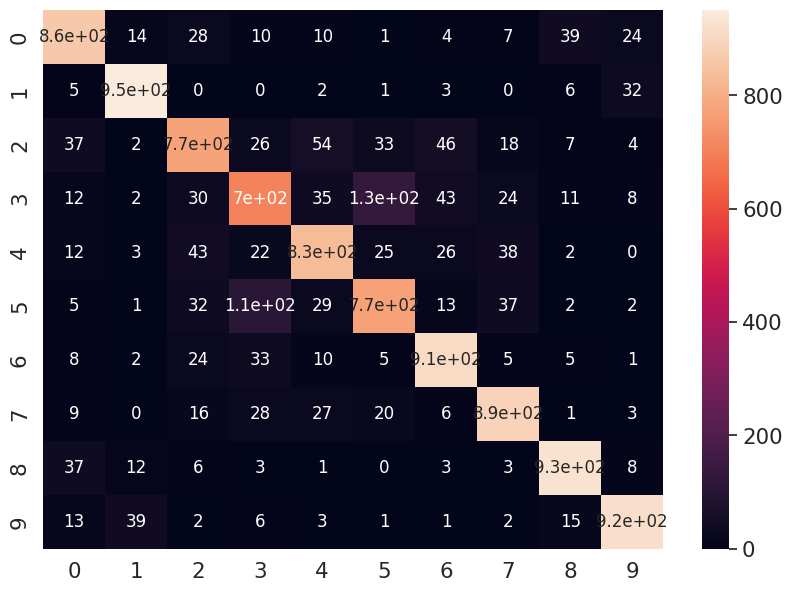

In [51]:
cm = confusion_matrix(la,
                      pred)

# Visualizing of confusion matrix
import seaborn as sn

df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size

## The END